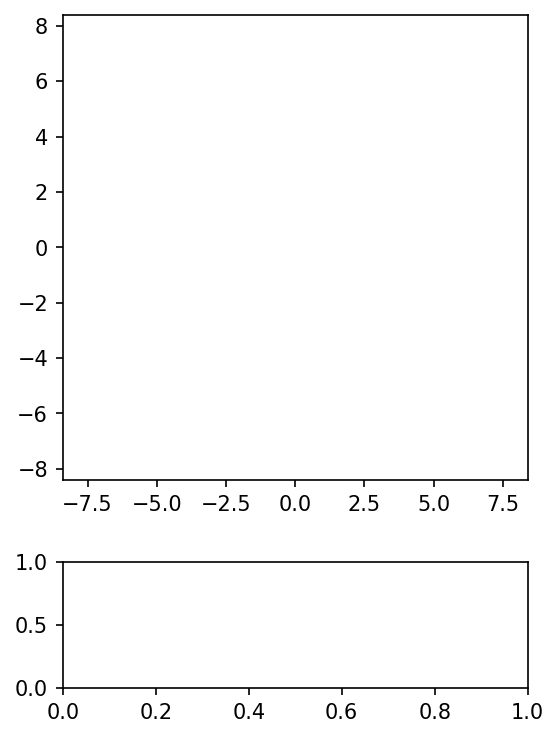

In [1]:

#--------------------------------- Librerias -----------------------------------

import numpy as np
import random
import math
import cmath
import pandas as pd

from numpy import linalg as LA

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from matplotlib.hatch import HorizontalHatch
import os
import csv

#------------------------------- General Config --------------------------------

IDEAL = False
DELTAt = 0
THERMOSTAT = 'None'

# N = 2*50
# r_2 = 4.0         #Disc 2 RatioTemp
# r_1 = 2.0         #Disc 1 Ratio
# r_G = 2.5         #Gap Ratio
# delta_r = r_G-r_1 #Gap thickness

# R = r_1*0.06

N = 2*8
r_2 = 8.0         #Disc 2 RatioTemp
r_1 = 4.0         #Disc 1 Ratio
r_G = 5.0         #Gap Ratio
delta_r = r_G-r_1 #Gap thickness

R = r_1*0.015

m = 1

Q_p = 1.0
Q_n = -Q_p

kB = 1

e0 = 1

Temp_Target = 1

Vm = list(np.arange(0,N))
Ke_Total_List = []
Ke_Mean_List = []
Pe_T_List = []
Vx_Mean_vec = []
Vy_Mean_vec = []
Temperature_Vec = []
VmComulate = []
Vb = list(np.arange(0,N))

Sqrt_Vel_Mean = 0

F = np.column_stack((np.zeros(N).tolist(),np.zeros(N).tolist()))
Fp = np.zeros(N).tolist()

#Nose-Hover-Verlet parameters
zeta = 0.0 #Initial zeta
xi = 0.1 #Relaxation parateter of the friction

#Langevin Thermostat
LambdaLG = 0.1

#Andersen Thermostat
GAMMA = 1

Ke_T = 0 #Energía cinética total
Ke_M = 0 #Energía cinética media

Pe_T = 0

ParticleData = pd.DataFrame()
SystemData = pd.DataFrame()

Fm = np.zeros(N).tolist()

Ke_p = np.zeros(N).tolist()

Step_List = []

#-------------------------------- Frontiers Plot -------------------------------

def plotFrontiers( show ) :
    figA, axFrontier = plt.subplots(dpi=141)
    axFrontier.set_aspect(1)
    axFrontier.set_xlim(-r_2-(0.05*r_2),r_2+(0.05*r_2))
    axFrontier.set_ylim(-r_2-(0.05*r_2),r_2+(0.05*r_2))
                
    plt.gca().set_aspect('equal') #Aspect ratio

    circle1 = plt.Circle((0,0), r_1, color='r')
    circle2 = plt.Circle((0,0), r_2, color='b')
    circleG = plt.Circle((0,0), r_G, color='r')
    
    pc = matplotlib.collections.PatchCollection([circle1,circle2,circleG],facecolor='none', edgecolor='black')
    
    axFrontier.add_collection(pc)    

    plt.xlabel("x")
    plt.ylabel("y")        
    if show : 
        plt.show()

#--------------------- Random nSteps coordinate pair values --------------------

#Generates nSteps random real numbers in [x1, x2]
def randomSet (x1, x2, nSteps ) : 
    randomlist = []
    for i in range(1, nSteps+1):
        number = random.uniform(x1, x2)
        randomlist.append(number)
    return np.array(randomlist) #Return a vector instead of a list   

def computeSize():
  figA, ax = plt.subplots(2,figsize=(4, 6),gridspec_kw={'height_ratios': [0.8, 0.2]},dpi=150)
  ax[0].set_aspect(1)
  ax[0].set_xlim(-r_2-(0.05*r_2),r_2+(0.05*r_2))
  ax[0].set_ylim(-r_2-(0.05*r_2),r_2+(0.05*r_2))
  particleSize = ((2*R*ax[0].get_window_extent().width  / (2*(4/np.pi)*(r_2+(0.1*r_2))) * 72./figA.dpi) ** 2)
  return particleSize

particleSize = computeSize()

In [2]:

#--------------- Generates random N/2 particles into r_1 circle ----------------

def CirclePoints (r,nSteps): 
    X_randomlist = []
    Y_randomlist = []
    for i in range(1, nSteps+1):
        Relation = random.uniform(0.0,1.0)
        Angle = random.uniform(0.0,1.0)*2*3.1416 #Generate a radom angle between 0,2PI
        x_number = (r*0.95)*math.cos(Angle) * Relation
        y_number = (r*0.95)*math.sin(Angle) * Relation

        X_randomlist.append(x_number)
        Y_randomlist.append(y_number)

    return np.array(X_randomlist),np.array(Y_randomlist) #Return a vector instead of a list

#------------- Generates random N/2 particles between r_G and R_2 --------------

def DonutPoints (nSteps): 
    X_randomlist = []
    Y_randomlist = []
    for i in range(1, nSteps+1):
        Ratio = random.uniform(r_G+(r_G*0.05),r_2-(r_2*0.05))
        Angle = random.uniform(0.0,1.0)*2*3.1416 #Generate a radom angle between 0,2PI
        x_number = Ratio*math.cos(Angle)
        y_number = Ratio*math.sin(Angle)

        X_randomlist.append(x_number)
        Y_randomlist.append(y_number)

    return np.array(X_randomlist),np.array(Y_randomlist) #Return a vector instead of a list

#-- Gen random particles positions: N/2 into r_1 and N/2 between r_G and r_2 --

def ParticlePos(show) : 
    global X, Y, Vx, Vy, IDEAL
    
    #POSITIONS
    Xr2,Yr2 = DonutPoints(int(N/2))
    Xr1,Yr1 = CirclePoints(r_1,int(N/2))

    XList = Xr1.tolist() + Xr2.tolist()
    YList = Yr1.tolist() + Yr2.tolist()
    X = np.array(XList)
    Y = np.array(YList)
    #---------------------------------------------------------------------------
    
    #Random Velocities
    if IDEAL == True:
        Vx = randomSet(-1,1,int(N))    
        Vy = randomSet(-1,1,int(N)) 
        
    else:
        Vx = np.zeros(N)
        Vy = np.zeros(N)

    if show :
        print("Initial random Positions")
        print("X=", X,len(X))
        print("Y=", Y,len(Y))
        print("Vx=", Vx, len(Vx))
        print("Vy=", Vy, len(Vy))
       
#------------------ Plot particles with their random positions -----------------

def plotParticles(show) : 
    global X, Y, Vx, Vy

    XList = X.tolist()
    YList = Y.tolist()

    Xr1_List = XList[0 : int(N/2)]
    Yr1_List = YList[0 : int(N/2)]

    Xr2_List = XList[int(N/2) : int(N)]
    Yr2_List = YList[int(N/2) : int(N)] 

    ax[0].scatter(Xr2_List, Yr2_List, c ="yellow",
            linewidths = 1,
            marker ="o",
            edgecolor ="black",
            s = particleSize)
    
    ax[0].scatter(Xr1_List, Yr1_List, c ="red",
            linewidths = 1,
            marker ="o",
            edgecolor ="black",
            s = particleSize)


In [3]:
# Frontier Collition detection (return state and ratio of collition frontier)

def frontierCollition(n,Xp,Yp) :
  global X, Y
  rCoord=np.sqrt(Xp**2 + Yp**2)
  
  #Collition with C1
  if n < int(N/2) : 
    if rCoord >= r_1 :
      return True,r_1
    else :
      return False,r_1

  #Collition with CG or C2  
  if n >= int(N/2):
    if rCoord <= r_G:
      return True,r_G
    elif rCoord >= r_2:
      return True,r_2
    else :
      return False,0

#------------------------------- Angle calculator ------------------------------

def Angle_Cal_Origin (X_Pos,Y_Pos):

  if X_Pos == 0.0 and Y_Pos == 0.0: #Si no hay desplazamiento, retorna un ángulo 0
      Angle = 0
  if X_Pos == 0.0 and Y_Pos > 0.0:  #Si sólo hay movimiento en Y positivo, retorna pi/2
    Angle = (math.pi)/2
  if X_Pos == 0.0 and Y_Pos < 0.0:  #Si sólo hay movimiento en Y negativo, retorna -pi/2
    Angle = (-1*(math.pi))/2
  if Y_Pos == 0.0 and X_Pos > 0.0:  #Si sólo hay movimiento en X positivo, retorna 0
    Angle = 0
  if Y_Pos == 0.0 and X_Pos < 0.0:  #Si sólo hay movimiento en X negativo, retorna pi
    Angle = math.pi
  
  abs_X_Pos = abs(X_Pos)
  abs_Y_Pos = abs(Y_Pos)

  #Cálculo dinámico de ángulos de movimiento
  if X_Pos > 0.0 and Y_Pos > 0.0:                 # Cuadrante 1
    Angle = math.atan(abs_Y_Pos/abs_X_Pos)
  if X_Pos < 0.0 and Y_Pos > 0.0:                 # Cuadrante 2
    Angle = ((math.pi)/2)+math.atan(abs_X_Pos/abs_Y_Pos)
  if X_Pos < 0.0 and Y_Pos < 0.0:                 # Cuadrante 3
    Angle = (-1*(math.pi)/2)-math.atan(abs_X_Pos/abs_Y_Pos)
  if X_Pos > 0.0 and Y_Pos < 0.0:                 # Cuadrante 4
    Angle = -1*math.atan(abs_Y_Pos/abs_X_Pos)

  return Angle

#------------------------- Collition Point calculator --------------------------

def CollitionPoint (Last_X,Last_Y,Next_X,Next_Y,Frontera):

  Delta_Y = Next_Y-Last_Y
  Delta_X = Next_X-Last_X

  if Delta_X == 0.0 or Delta_Y==0.0:
    return Last_X,Last_Y,0

  m = (Delta_Y)/(Delta_X)
  b = Last_Y-(m*Last_X)

  A = 1+(m**2)
  B = 2*b*m
  C = ((b**2)-(Frontera**2))
  
  try:
    Choque_Xp = (-B+(math.sqrt((B**2)-(4*A*C))))/(2*A)  
    Choque_Xn = (-B-(math.sqrt((B**2)-(4*A*C))))/(2*A)  
    
  except Exception as e:
    
    Choque_Xp = (-B+(cmath.sqrt((B**2)-(4*A*C))))/(2*A)
    Choque_Xn = (-B-(cmath.sqrt((B**2)-(4*A*C))))/(2*A)
    
    Choque_Xp = Choque_Xp.real
    Choque_Xn = Choque_Xn.real

  Choque_Yp = (m*Choque_Xp)+b
  Choque_Yn = (m*Choque_Xn)+b

  Ratio_p = math.sqrt((Choque_Xp**2)+(Choque_Yp**2))
  Ratio_n = math.sqrt((Choque_Xn**2)+(Choque_Yn**2))

  Ratio_p = round(Ratio_p,2)
  Ratio_n = round(Ratio_n,2)

  Delta_Choque_Xp = Choque_Xp - Last_X
  Delta_Choque_Yp = Choque_Yp - Last_Y

  Delta_Choque_Xn = Choque_Xn - Last_X
  Delta_Choque_Yn = Choque_Yn - Last_Y

  Vec_Delta = [Delta_X,Delta_Y]
  Vec_ChoqP = [Delta_Choque_Xp,Delta_Choque_Yp]
  Vec_ChoqN = [Delta_Choque_Xn,Delta_Choque_Yn]

  Dot_p = np.dot(Vec_Delta,Vec_ChoqP)
  Dot_n = np.dot(Vec_Delta,Vec_ChoqN)

  if Frontera == r_1 or Frontera == r_2:
    if Dot_p >= 0:
      Angle = Angle_Cal_Origin(Choque_Xp,Choque_Yp)
      return Choque_Xp,Choque_Yp,Angle

    elif Dot_n >= 0:
      Angle = Angle_Cal_Origin(Choque_Xn,Choque_Yn)
      return Choque_Xn,Choque_Yn,Angle

    elif Dot_p > Dot_n:
      Angle = Angle_Cal_Origin(Choque_Xp,Choque_Yp)
      return Choque_Xp,Choque_Yp,Angle
      
    elif Dot_n > Dot_p:
      Angle = Angle_Cal_Origin(Choque_Xn,Choque_Yn)
      return Choque_Xn,Choque_Yn,Angle
    
  else:
    if Dot_p <= 0:
      Angle = Angle_Cal_Origin(Choque_Xp,Choque_Yp)
      return Choque_Xp,Choque_Yp,Angle

    elif Dot_n <= 0:
      Angle = Angle_Cal_Origin(Choque_Xn,Choque_Yn)
      return Choque_Xn,Choque_Yn,Angle

    elif Dot_p < Dot_n:
      Angle = Angle_Cal_Origin(Choque_Xp,Choque_Yp)
      return Choque_Xp,Choque_Yp,Angle

    elif Dot_n < Dot_p:
      Angle = Angle_Cal_Origin(Choque_Xn,Choque_Yn)
      return Choque_Xn,Choque_Yn,Angle
    
  if Vec_ChoqN == Vec_ChoqP:
    Angle = Angle_Cal_Origin(Choque_Xp,Choque_Yp)
    return Choque_Xp,Choque_Yp,Angle

#------------------ Calculator of Velocities after Collition -------------------

def newVelocities( VxOld, VyOld, phi_c ) :
  VxNew = -VxOld*np.cos(2*phi_c)-VyOld*np.sin(2*phi_c)
  VyNew = -VxOld*np.sin(2*phi_c)+VyOld*np.cos(2*phi_c)
  return VxNew, VyNew


In [4]:
from numpy.linalg import norm

def hardDiskCollision(rVecList1, rVecList2, uVecList, vVecList) :    
  x1, y1 = rVecList1
  x2, y2 = rVecList2
  uxVal, uyVal = uVecList
  vxVal, vyVal = vVecList
          
  rVector1 = np.array(rVecList1) 
  rVector2 = np.array(rVecList2) 
  uVector = np.array(uVecList) 
  vVector = np.array(vVecList) 

  rVector12 = rVector2-rVector1
  rVec12Distance = norm(rVector12)
  rVector12Unit = rVector12/rVec12Distance

  cosphi, sinphi = rVector12[0]/rVec12Distance, rVector12[1]/rVec12Distance

  #Unit vectors of the cartesian coordinate system
  xUnit = np.array([1, 0])
  yUnit = np.array([0, 1])

  #Rotation matrix and its inverse
  RMatrix = np.array([[cosphi, -sinphi], [sinphi, cosphi]])
  RMatrixInv = np.array([[cosphi, sinphi], [-sinphi, cosphi]])
      

  #Step 1. Unit vectors in the rotated system
  xUnitTilde = np.dot(RMatrix,xUnit)   #xUnitTilde = np.array([cosphi, -sinphi])
  yUnitTilde = np.dot(RMatrix,yUnit)   #yUnitTilde = np.array([sinphi, cosphi])
      
  #Step 2. Velocities vectors in the rotated system
  uVectorTilde = np.dot(RMatrixInv,uVector)
  vVectorTilde = np.dot(RMatrixInv,vVector)
  #Components
  uxTilde, uyTilde = uVectorTilde[0], uVectorTilde[1]
  vxTilde, vyTilde = vVectorTilde[0], vVectorTilde[1]
      
  #New velocities (in the non-rotated cartesian system)
  uNewVectorTilde = vxTilde*xUnitTilde + uyTilde*yUnitTilde
  vNewVectorTilde = uxTilde*xUnitTilde + vyTilde*yUnitTilde

  uNewVector = uNewVectorTilde
  vNewVector = vNewVectorTilde

  #New positions
  rVectorMid = (rVector1+rVector2)/2.0  #middle position where paticles collide
  rNewVector1 = rVectorMid - 1.01*R*rVector12Unit 
  rNewVector2 = rVectorMid + 1.01*R*rVector12Unit 

  x1, y1 = rNewVector1.tolist()
  x2, y2 = rNewVector2.tolist()
  uxVal, uyVal = uNewVector.tolist()
  vxVal, vyVal = vNewVector.tolist()    
    
  return rNewVector1.tolist(), rNewVector2.tolist(), uNewVector.tolist(), vNewVector.tolist()

def checkCollisions():
    
    X_mat = np.array(X).reshape(N, 1)
    Y_mat = np.array(Y).reshape(N, 1)
    
    X_mat = X_mat - X_mat.T
    Y_mat = Y_mat - Y_mat.T
    Vx_mat = np.array(Vx).reshape(N, 1) - np.array(Vx).reshape(N, 1).T
    Vy_mat = np.array(Vy).reshape(N, 1) - np.array(Vy).reshape(N, 1).T
    
    dist_mat = np.sqrt(X_mat**2 + Y_mat**2)
    overlap_mat = dist_mat < 2 * R
    
    collision_indices = np.triu(overlap_mat, k=1).nonzero()
    
    for i, n in zip(*collision_indices):
        XiNew, YiNew, VxiNew, VyiNew = X[i], Y[i], Vx[i], Vy[i]
        XnNew, YnNew, VxnNew, VynNew = X[n], Y[n], Vx[n], Vy[n]
        
        [X[i],Y[i]],[X[n],Y[n]],[Vx[i],Vy[i]],[Vx[n],Vy[n]] = hardDiskCollision([XiNew, YiNew], [XnNew, YnNew], [VxiNew, VyiNew], [VxnNew, VynNew])


In [5]:
from matplotlib.hatch import HorizontalHatch

def Velocities_Mag ():
  global Vx, Vy, Vm

  for n in range(0, int(N)) :
    Vm[n] = math.sqrt(((Vx[n])**2)+((Vy[n])**2))

  Vm = np.array(Vm)
  Mean = np.mean(Vm**2)
  
  return Mean

def XVel_Mean ():
  global Vx
  return np.mean(Vx)

def YVel_Mean ():
  global Vy
  return np.mean(Vy)

def Mean_Kinetic_Energy ():
  global Sqrt_Vel_Mean

  K = 0.5*m*Sqrt_Vel_Mean
  return K

def Temperature_Cal (K):
  global kB
  
  T = K/kB
  return T

#------------- Movement funtion: Update positions and velocitites --------------

def magnitude(vector) : 
    return LA.norm(vector)

def q(n) :
    if IDEAL == True:
      return 0
    else: 
      if n < N/2: 
        return Q_p # n will start at zero
      else : 
        return Q_n

def Coulomb_Force_Cal(X, Y):
  global F,e0
  
  k_e = 1 / (4 * np.pi * e0)
  
  # Crea una matriz de cargas utilizando la función q(n)
  cargas = np.array([q(n) for n in range(int(N))])

  # Crea matrices de diferencias de posiciones
  dx = X.reshape(N, 1) - X
  dy = Y.reshape(N, 1) - Y

  # Calcula las distancias al cuadrado y evita la división por cero
  distancia_cuadrado = np.maximum(dx**2 + dy**2, 1e-12)

  # Calcula las fuerzas de Coulomb
  fuerzas = (k_e * cargas.reshape(N, 1) * cargas) / distancia_cuadrado

  # Elimina la diagonal (autointeracción) y suma las fuerzas en el eje Y y X
  np.fill_diagonal(fuerzas, 0)
  fuerzas_x = np.sum(fuerzas * (dx / np.sqrt(distancia_cuadrado)), axis=1)
  fuerzas_y = np.sum(fuerzas * (dy / np.sqrt(distancia_cuadrado)), axis=1)
  
  F = np.column_stack((fuerzas_x, fuerzas_y))
  
  return F

# def Coulomb_Force_Cal (x,y):
  
#   F = []

#   rVector = np.column_stack((x,y)) #position vector

#   Conts = 1/(4*np.pi*e0)

#   for i in range(0, int(N)):
#     Sum = 0
#     Qi = q(i)
#     for n in range(0, int(N)) :        
#       if n != i :
#         r12 = magnitude(rVector[i]-rVector[n])
#         Sum = Sum+((q(n)*(rVector[i]-rVector[n]))/(r12**3))
#         # print("Partícula: ",n," Sum: ", Sum)
    
#     F.append(Conts*Qi*Sum)

#   return F

def Potencial_Energy(x,y):
    rVector = np.column_stack((x, y))  # posición vectorial
    Conts = 1 / (4 * np.pi * e0)
    Q = np.array([q(n) for n in range(N)])

    # Calcula las distancias de manera eficiente usando broadcasting
    r_diff = rVector[:, np.newaxis, :] - rVector
    distances = np.linalg.norm(r_diff, axis=2)
    np.fill_diagonal(distances, 1.0)  # Evitar la división por cero para las partículas coincidentes

    # Calcula la energía potencial usando cálculos matriciales
    energy_matrix = Q[:, np.newaxis] * Q * Conts / distances
    np.fill_diagonal(energy_matrix, 0.0)  # Excluye la contribución propia

    Sum_m = np.sum(energy_matrix)

    return Sum_m

def moveD() :           # Sin Termostato
  global X, Y, Vx, Vy,F,Fp, DELTAt, IDEAL, F

  if IDEAL == False:
    #Approx : Velocity Verlet integrators 
    F=np.vstack(Coulomb_Force_Cal(X,Y))  #Compute the forces. F[i] is the force on the ith-particle 
    ax=F[:,0]/m               #Total x-acceleration on each particle
    ay=F[:,1]/m               #Total y-acceleration on each particle
    #New position
    Xp = X+Vx*DELTAt + 0.5*ax*DELTAt**2
    Yp = Y+Vy*DELTAt + 0.5*ay*DELTAt**2
    #New acceleration
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp)) #Compute the forces. F[i] is the force on the ith-particle 
    axp=Fp[:,0]/m #Total x-acceleration on each particle
    ayp=Fp[:,1]/m #Total y-acceleration on each particle
    #Verlet velocity
    Vxp = Vx + 0.5*(ax+axp)*DELTAt
    Vyp = Vy + 0.5*(ay+ayp)*DELTAt
    
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

  else:
    Xp = X+Vx*DELTAt 
    Yp = Y+Vy*DELTAt
    
    Vxp = Vx 
    Vyp = Vy 
        
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt
    
# Reescalado de velocidades
def Vel_Rescaling(Velx,Vely,Temp_Act):
  global Temp_Target
  
  V_x = Velx * math.sqrt(Temp_Target/Temp_Act)
  V_y = Vely * math.sqrt(Temp_Target/Temp_Act)
  
  return V_x,V_y
    
def moveVR():
  global X, Y, Vx, Vy,F,Fp, DELTAt, IDEAL, Sqrt_Vel_Mean, F

  if IDEAL == False:
    #Approx : Velocity Verlet integrators 
    F=np.vstack(Coulomb_Force_Cal(X,Y))  #Compute the forces. F[i] is the force on the ith-particle 
    ax=F[:,0]/m               #Total x-acceleration on each particle
    ay=F[:,1]/m               #Total y-acceleration on each particle
    #New position
    Xp = X+Vx*DELTAt + 0.5*ax*DELTAt**2
    Yp = Y+Vy*DELTAt + 0.5*ay*DELTAt**2
    #New acceleration
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp)) #Compute the forces. F[i] is the force on the ith-particle 
    axp=Fp[:,0]/m #Total x-acceleration on each particle
    ayp=Fp[:,1]/m #Total y-acceleration on each particle
    #Verlet velocity
    Vxp = Vx + 0.5*(ax+axp)*DELTAt
    Vyp = Vy + 0.5*(ay+ayp)*DELTAt
    
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

  else:
    Xp = X+Vx*DELTAt 
    Yp = Y+Vy*DELTAt
    
    Vxp = Vx 
    Vyp = Vy 
        
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt
  
  #Velocity rescaling
  Sqrt_Vel_Mean = Velocities_Mag()
  Ke_M = Mean_Kinetic_Energy()
  T = Temperature_Cal(Ke_M)
  for n in range(0, int(N)) :
    Vx[n], Vy[n]=Vel_Rescaling(Vx[n],Vy[n],T)

def Total_KEnergy(Vx,Vy):    
  global m, N
  
  energySum = 0
  
  for i in range(0,N) :
      energySum = energySum + 0.5*m*((Vx[i]**2)+(Vy[i]**2))
  
  return energySum

def moveNH():
  global X, Y, Vx, Vy,F,Fp, DELTAt, IDEAL, zeta, xi, N, Ke_T, Ke_M, F
  
  if IDEAL == False:
    #Approx : Velocity Verlet integrators 
    F=np.vstack(Coulomb_Force_Cal(X,Y))  #Compute the forces. F[i] is the force on the ith-particle 
    ax=F[:,0]/m               #Total x-acceleration on each particle
    ay=F[:,1]/m               #Total y-acceleration on each particle
    
    #New position
    Xp = X + Vx*DELTAt + ((ax-zeta*Vx)*(0.5*(DELTAt**2)))
    Yp = Y + Vy*DELTAt + ((ay-zeta*Vy)*(0.5*(DELTAt**2)))

    Ke_T = Total_KEnergy(Vx,Vy)
    
    #At t + tDelta/2
    Vx_pp  = Vx + ((0.5*DELTAt)*(ax-(zeta*Vx)))           # Eq. 40
    Vy_pp  = Vy + ((0.5*DELTAt)*(ay-(zeta*Vy)))           # Eq. 40
    Ke_Tpp = Total_KEnergy(Vx_pp,Vy_pp)
    zetapp = zeta + (xi*0.5*DELTAt*(Ke_T-((((2*N)+1)*0.5)*kB*Temp_Target)))   # Eq. 36
    
    #At t + tDelta
    zetap = zetapp +(xi*0.5*DELTAt*(Ke_Tpp-((((2*N)+1)*0.5)*kB*Temp_Target)))  # Eq. 36
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp))
    axp=Fp[:,0]/m
    ayp=Fp[:,1]/m
    #Verlet velocity with the news force
    Vxp = (Vx_pp + (0.5*DELTAt*axp))/(1+(0.5*DELTAt*zetap))
    Vyp = (Vy_pp + (0.5*DELTAt*ayp))/(1+(0.5*DELTAt*zetap))
    zeta = zetap #Update the value of zeta(t)
    
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt
            
  else:
    ax = np.zeros(N)
    ay = np.zeros(N)
    
    #New position
    Xp = X + Vx*DELTAt + ((ax-zeta*Vx)*(0.5*(DELTAt**2)))
    Yp = Y + Vy*DELTAt + ((ay-zeta*Vy)*(0.5*(DELTAt**2)))

    Ke_T = Total_KEnergy(Vx,Vy)
    
    #At t + tDelta/2
    Vx_pp  = Vx + ((0.5*DELTAt)*(ax-(zeta*Vx)))           # Eq. 40
    Vy_pp  = Vy + ((0.5*DELTAt)*(ay-(zeta*Vy)))           # Eq. 40
    Ke_Tpp = Total_KEnergy(Vx_pp,Vy_pp)
    zetapp = zeta + (xi*0.5*DELTAt*(Ke_T-((((2*N)+1)*0.5)*kB*Temp_Target)))   # Eq. 36
    
    #At t + tDelta
    zetap = zetapp +(xi*0.5*DELTAt*(Ke_Tpp-((((2*N)+1)*0.5)*kB*Temp_Target)))  # Eq. 36
    axp=np.zeros(N)
    ayp=np.zeros(N)
    #Verlet velocity with the news force
    Vxp = (Vx_pp + (0.5*DELTAt*axp))/(1+(0.5*DELTAt*zetap))
    Vyp = (Vy_pp + (0.5*DELTAt*ayp))/(1+(0.5*DELTAt*zetap))
    zeta = zetap #Update the value of zeta(t)
        
    for n in range(0, int(N)) :
      Collition,F = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],F)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

def moveLG():
  global X, Y, Vx, Vy,F,Fp, DELTAt, IDEAL, LambdaLG, F

  if IDEAL == False:
    #Approx : Velocity Verlet integrators 
    F=np.vstack(Coulomb_Force_Cal(X,Y))  #Compute the forces. F[i] is the force on the ith-particle 
    ax=F[:,0]/m               #Total x-acceleration on each particle
    ay=F[:,1]/m               #Total y-acceleration on each particle
    
    Rx = np.random.normal(0, 1, size=N)
    Ry = np.random.normal(0, 1, size=N)
    
    Vxpp = Vx - (0.5*DELTAt*(-ax+LambdaLG*Vx)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Rx
    Vypp = Vy - (0.5*DELTAt*(-ay+LambdaLG*Vy)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Ry
    
    #New position
    Xp = X+Vxpp*DELTAt
    Yp = Y+Vypp*DELTAt
    
    #New acceleration
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp)) #Compute the forces. F[i] is the force on the ith-particle 
    axp=Fp[:,0]/m #Total x-acceleration on each particle
    ayp=Fp[:,1]/m #Total y-acceleration on each particle
    
    Rx = np.random.normal(0, 1, size=N)
    Ry = np.random.normal(0, 1, size=N)
    
    #Verlet velocity
    Vxp = Vxpp - (0.5*DELTAt*(-axp+LambdaLG*Vxpp)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Rx
    Vyp = Vypp - (0.5*DELTAt*(-ayp+LambdaLG*Vypp)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Ry
    
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

  else:
    
    ax = np.zeros(N)
    ay = np.zeros(N)
    
    Rx = np.random.normal(0, 1, size=N)
    Ry = np.random.normal(0, 1, size=N)
    
    Vxpp = Vx - (0.5*DELTAt*(-ax+LambdaLG*Vx)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Rx
    Vypp = Vy - (0.5*DELTAt*(-ay+LambdaLG*Vy)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Ry
    
    #New position
    Xp = X+Vxpp*DELTAt
    Yp = Y+Vypp*DELTAt
    
    #New acceleration
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp)) #Compute the forces. F[i] is the force on the ith-particle 
    axp=Fp[:,0]/m #Total x-acceleration on each particle
    ayp=Fp[:,1]/m #Total y-acceleration on each particle
    
    Rx = np.random.normal(0, 1, size=N)
    Ry = np.random.normal(0, 1, size=N)
    
    #Verlet velocity
    Vxp = Vxpp - (0.5*DELTAt*(-axp+LambdaLG*Vxpp)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Rx
    Vyp = Vypp - (0.5*DELTAt*(-ayp+LambdaLG*Vypp)) + np.sqrt((DELTAt*kB*Temp_Target*LambdaLG)/m)*Ry
        
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

def moveAD():
  global X, Y, Vx, Vy,F,Fp, DELTAt, IDEAL, Sqrt_Vel_Mean, GAMMA, F

  if IDEAL == False:
    #Approx : Velocity Verlet integrators 
    F=np.vstack(Coulomb_Force_Cal(X,Y))  #Compute the forces. F[i] is the force on the ith-particle 
    ax=F[:,0]/m               #Total x-acceleration on each particle
    ay=F[:,1]/m               #Total y-acceleration on each particle
    #New position
    
    Xp = X+Vx*DELTAt + 0.5*ax*DELTAt**2
    Yp = Y+Vy*DELTAt + 0.5*ay*DELTAt**2
    #New acceleration
    Fp=np.vstack(Coulomb_Force_Cal(Xp,Yp)) #Compute the forces. F[i] is the force on the ith-particle 
    axp=Fp[:,0]/m #Total x-acceleration on each particle
    ayp=Fp[:,1]/m #Total y-acceleration on each particle
    #Verlet velocity
    Vxp = Vx + 0.5*(ax+axp)*DELTAt
    Vyp = Vy + 0.5*(ay+ayp)*DELTAt
    
    # Termostato de Andersen
    for i in range(int(N)):
      if np.random.random() < GAMMA:
        Vx[i] = np.random.normal(0, np.sqrt(kB * Temp_Target / m))
        Vy[i] = np.random.normal(0, np.sqrt(kB * Temp_Target / m))
    
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

  else:
    Xp = X+Vx*DELTAt 
    Yp = Y+Vy*DELTAt
    
    Vxp = Vx 
    Vyp = Vy 
    
    # Termostato de Andersen
    for i in range(int(N)):
      if np.random.random() < GAMMA:
        Vx[i] = np.random.normal(0, np.sqrt(kB * Temp_Target / m))
        Vy[i] = np.random.normal(0, np.sqrt(kB * Temp_Target / m))
        
    for n in range(0, int(N)) :
      Collition,Front = frontierCollition(n,Xp[n],Yp[n])
      if Collition == False:
        X[n] = Xp[n]
        Y[n] = Yp[n]
        Vx[n] = Vxp[n]
        Vy[n] = Vyp[n]
      else:
        X[n],Y[n],Angle_c=CollitionPoint (X[n],Y[n],Xp[n],Yp[n],Front)
        Vx[n], Vy[n] = newVelocities( Vx[n], Vy[n], Angle_c ) #update
        X[n] = X[n]+Vx[n]*DELTAt 
        Y[n] = Y[n]+Vy[n]*DELTAt

#---------------------------- Stack Movement steps ----------------------------

def animate(n1) :
  global X,Y,Sqrt_Vel_Mean,Ke_Mean_List,Vx_Mean_vec,Vy_Mean_vec

  ax[0].cla()
  ax[1].cla()

  circle1 = plt.Circle((0,0), r_1, color='r')
  circle2 = plt.Circle((0,0), r_2, color='b')
  circleG = plt.Circle((0,0), r_G, color='r')

  pc = matplotlib.collections.PatchCollection([circle1,circle2,circleG],facecolor='none', edgecolor='black')
  ax[0].add_collection(pc)    

  for the_counter in range(0, int(50)) :
    if THERMOSTAT == 'VR':
      moveVR()
    elif THERMOSTAT == 'NH':
      moveNH()
    elif THERMOSTAT == 'LG':
      moveLG()
    elif THERMOSTAT == 'AD':
      moveAD()
    else:
      moveD()
      
    checkCollisions()            

  ax[0].quiver(X.tolist(), Y.tolist(), Vx.tolist(), Vy.tolist(), color='b', units='xy', linewidths=0.4, width=0.02, scale=1, ls='solid',fc='w', edgecolor='black', alpha=0.2)

  ax[1] = sns.distplot(Vm,norm_hist=True)

  print("n1 =",n1+1, " of ", frameSteps)
  plotParticles (True)

In [6]:

output_dir = r"D:\Drive ECCI\MD Project\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\18. Paper_Correct\2. N_8\5. B0_25"
filename = "animacion.gif"
output_path = os.path.join(output_dir, filename)

# --------------------------- Simulation Conditions ---------------------------

PC_ID = "Equipo Personal"
IDEAL = False
THERMOSTAT = 'LG'
DELTAt = 0.001
ANIMATE1 = True
ANIMATE2 = True

Temp_Target = 0.25

totalSteps = 3000000
Saving_Steps = 2000
Saving_Steps_Str = str(Saving_Steps)

#Nose-Hover-Verlet parameters
zeta = 0.0 #Initial zeta

# xi = 0.8
# xi = ((xi/(2*np.pi))**2) * (2*(2*N)*kB*Temp_Target)
# xi = 1/xi

xi = (3.0*N+1.0)*kB*Temp_Target*2.0
xi = 1/xi

Q_p = 1.0
Q_n = -Q_p

#------------------------------ Exec Intructions ------------------------------

ParticlePos (show = False)              # Generate random X,Y initial positions

#----------------------------- Animate Graph config ----------------------------

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots(2,figsize=(4, 6),gridspec_kw={'height_ratios': [0.8, 0.2]})
frameSteps = 100

#------------ Exec movement with Animate funtion (stack movements) -------------

if ANIMATE1 == True:
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frameSteps)
    ani.save(output_path, writer="Pillow")
    
# matplotlib.animation.FuncAnimation(fig, animate, frames=frameSteps)


MovieWriter Pillow unavailable; using Pillow instead.


n1 = 1  of  100
n1 = 1  of  100
n1 = 2  of  100
n1 = 3  of  100
n1 = 4  of  100
n1 = 5  of  100
n1 = 6  of  100
n1 = 7  of  100
n1 = 8  of  100
n1 = 9  of  100
n1 = 10  of  100
n1 = 11  of  100
n1 = 12  of  100
n1 = 13  of  100
n1 = 14  of  100
n1 = 15  of  100
n1 = 16  of  100
n1 = 17  of  100
n1 = 18  of  100
n1 = 19  of  100
n1 = 20  of  100
n1 = 21  of  100
n1 = 22  of  100
n1 = 23  of  100
n1 = 24  of  100
n1 = 25  of  100
n1 = 26  of  100
n1 = 27  of  100
n1 = 28  of  100
n1 = 29  of  100
n1 = 30  of  100
n1 = 31  of  100
n1 = 32  of  100
n1 = 33  of  100
n1 = 34  of  100
n1 = 35  of  100
n1 = 36  of  100
n1 = 37  of  100
n1 = 38  of  100
n1 = 39  of  100
n1 = 40  of  100
n1 = 41  of  100
n1 = 42  of  100
n1 = 43  of  100
n1 = 44  of  100
n1 = 45  of  100
n1 = 46  of  100
n1 = 47  of  100
n1 = 48  of  100
n1 = 49  of  100
n1 = 50  of  100
n1 = 51  of  100
n1 = 52  of  100
n1 = 53  of  100
n1 = 54  of  100
n1 = 55  of  100
n1 = 56  of  100
n1 = 57  of  100
n1 = 58  of  100
n1 = 59

In [7]:
def create_csv_file(data_name, out_dir, columns):
    file_name = f"{data_name}.csv"
    file_path = os.path.join(out_dir, file_name)
    
    with open(file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(columns)

def add_data_to_csv(path, data):
    with open(path, 'a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(data)

def add_long_lists_to_csv(path, column_indices, lists):
    rows = zip(*lists)  # Transpose lists to create rows
    
    with open(path, 'a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        for row in rows:
            data = [''] * len(column_indices)  # Create empty data list
            
            for i, value in zip(column_indices, row):
                if isinstance(value, float):
                    formatted_value = "{:.9f}".format(value)
                    data[i] = formatted_value.replace('.', ',')
                else:
                    data[i] = value
            
            writer.writerow(data)

In [8]:
fig3, ax3 = plt.subplots(dpi=100)

Particles = list(range(1, N+1))

List_Data1 = ['Step', 'Particle', 'X_Pos', 'Y_Pos', 'Vel_X', 
              'Vel_Y', 'Vel_M', 'Force_X', 'Force_Y', 'Force_T', 'Ke_Energy']

List_Data2 = ['Step', 'Ke_T', 'Ke_M', 'Temp_Act',
              'Temp_Tar', 'Vx_Mean', 'Vy_Mean','Pot_Energy']

# Índices de columna correspondientes
column_indices1 = list(range(len(List_Data1)))
column_indices2 = list(range(len(List_Data2)))

Par_data_name = 'Particle_Data'
csv_file_path = f"{output_dir}/{Par_data_name}.csv"
create_csv_file(Par_data_name, output_dir, List_Data1)

for the_counter in range(0, int(totalSteps)) :
  
  Last_Step = [the_counter+1] * N
  
  if THERMOSTAT == 'VR':
    moveVR()
  elif THERMOSTAT == 'NH':
    moveNH()
  elif THERMOSTAT == 'LG':
    moveLG()
  elif THERMOSTAT == 'AD':
    moveAD()
  else:
    moveD()
    
  Sqrt_Vel_Mean = Velocities_Mag()
  checkCollisions()

  if (the_counter+1)%Saving_Steps == 0:
    print("progress = ", the_counter*100.0/totalSteps)
    
    VmComulate = np.concatenate((VmComulate, Vm), axis=None)
    Step_List.append(the_counter+1)

    Sqrt_Vel_Mean = Velocities_Mag()
    Xvel_Mean = XVel_Mean()
    Vx_Mean_vec.append(Xvel_Mean)

    Yvel_Mean = YVel_Mean()
    Vy_Mean_vec.append(Yvel_Mean)

    Ke_T = Total_KEnergy(Vx,Vy)
    Ke_Total_List.append(Ke_T)
    
    Ke_Mean = Mean_Kinetic_Energy()
    Ke_Mean_List.append(Ke_Mean)
    
    Pe_T = Potencial_Energy(X,Y)
    Pe_T_List.append(Pe_T)
    
    T = Temperature_Cal (Ke_Mean)
    Temperature_Vec.append(T)
    
    for n in range(0, int(N)) :
      
      if IDEAL == True:
        F = np.zeros((N, 2))
      
      Vm[n] = math.sqrt(((Vx[n])**2)+((Vy[n])**2))
      Fm[n] = math.sqrt(((F[n,0])**2)+((F[n,1])**2))
      Ke_p[n] = 0.5*m*((Vx[n]**2)+(Vy[n]**2))

    add_long_lists_to_csv(csv_file_path, column_indices1, [Last_Step, Particles, X, Y, Vx, Vy, Vm, F[:,0], F[:,1], Fm, Ke_p])


progress =  0.06663333333333334
progress =  0.1333
progress =  0.19996666666666665
progress =  0.26663333333333333
progress =  0.3333
progress =  0.3999666666666667
progress =  0.46663333333333334
progress =  0.5333
progress =  0.5999666666666666
progress =  0.6666333333333333
progress =  0.7333
progress =  0.7999666666666667
progress =  0.8666333333333334
progress =  0.9333
progress =  0.9999666666666667
progress =  1.0666333333333333
progress =  1.1333
progress =  1.1999666666666666
progress =  1.2666333333333333
progress =  1.3333
progress =  1.3999666666666666
progress =  1.4666333333333332
progress =  1.5333
progress =  1.5999666666666668
progress =  1.6666333333333334
progress =  1.7333
progress =  1.7999666666666667
progress =  1.8666333333333334
progress =  1.9333
progress =  1.9999666666666667
progress =  2.0666333333333333
progress =  2.1333
progress =  2.1999666666666666
progress =  2.2666333333333335
progress =  2.3333
progress =  2.399966666666667
progress =  2.46663333333

In [9]:
Temp_Tar_List = [Temp_Target] * len(Step_List)

Sys_data_name = 'System_Data'
csv_file_path = f"{output_dir}/{Sys_data_name}.csv"

create_csv_file(Sys_data_name, output_dir, List_Data2)
add_long_lists_to_csv(csv_file_path, column_indices2, [Step_List, Ke_Total_List , Ke_Mean_List, Temperature_Vec, Temp_Tar_List, Vx_Mean_vec , Vy_Mean_vec,Pe_T_List])

print(VmComulate)
print(len(VmComulate))

[0.60091605 0.59443521 0.0852536  ... 0.4657272  0.74191457 0.57184099]
24000


Ke:  [0.17065822729085534, 0.18499354619465583, 0.19680288797554274, 0.17452068250648106, 0.23377732740159213, 0.2424165885690218, 0.2456523393566343, 0.1962466030312237, 0.20745738355447185, 0.2480472161945021, 0.247137975845722, 0.20472631506002753, 0.18887242816125033, 0.24661848470202355, 0.16427325369567508, 0.27751671641067227, 0.2996951206816856, 0.2433033852381014, 0.24911567866176282, 0.14599741910415145, 0.14186584621493775, 0.2468206651863504, 0.25547818842575365, 0.2084251182058871, 0.204176200018431, 0.1530165457117697, 0.19841014988113181, 0.2683624567674266, 0.27943408266524694, 0.1822792563420302, 0.18340644652418936, 0.1778866148348724, 0.21075390645118774, 0.22381969866354892, 0.2754234688007503, 0.2540526702349475, 0.2590838633442875, 0.24371565862150177, 0.2121684623903597, 0.1665517580002866, 0.20959876349868783, 0.25820557459371357, 0.2188509033138657, 0.2620335423263665, 0.21291557826588378, 0.1756338204491961, 0.18026694558691642, 0.26076418310714944, 0.28868338

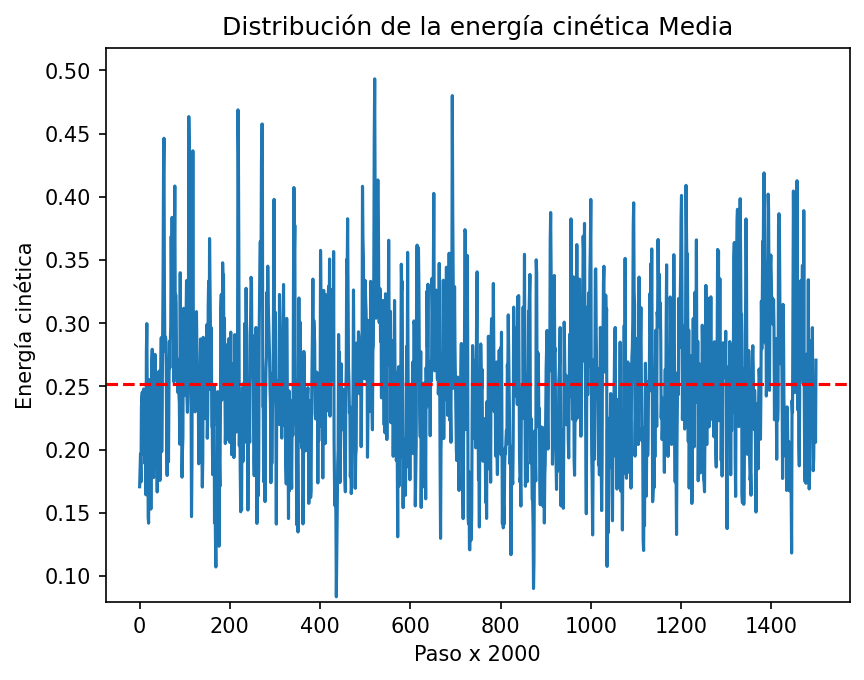

Vx_Mean_vec:  [-0.1521282937121957, -0.20891895536072463, -0.13137152465575472, 0.04023106599404397, -0.047321567318903426, 0.14383396368430937, 0.08615039866737695, -0.030561949703041748, 0.008702777461540787, -0.10043116712802233, 0.03777093772398643, 0.1921895932091096, 0.22291562523158687, -0.005554539254163042, -0.053024477527435054, 0.0033679937134531712, -0.07977569024376585, -0.04912105409855971, -0.13986622182040886, 0.04085796633645921, 0.08025627399931445, -0.01452325453263531, -0.17346266772208968, -0.042909563300783216, 0.16264572861854001, 0.14772614767196143, 0.2639559986669906, 0.06082272290518924, 0.04934477977026568, 0.056724540215554495, 0.09326165714906615, 0.0687257690561593, -0.011699683061139166, -0.14848820110353356, -0.13065653498742327, -0.0056373854271665885, -0.14208904421656593, -0.0025548401003755855, 0.05861944112868969, 0.0652971935451305, 0.024356046661495337, 0.13776821901950173, -0.03348896250896871, -0.003863434993145159, 0.08569621745102438, -0.0752

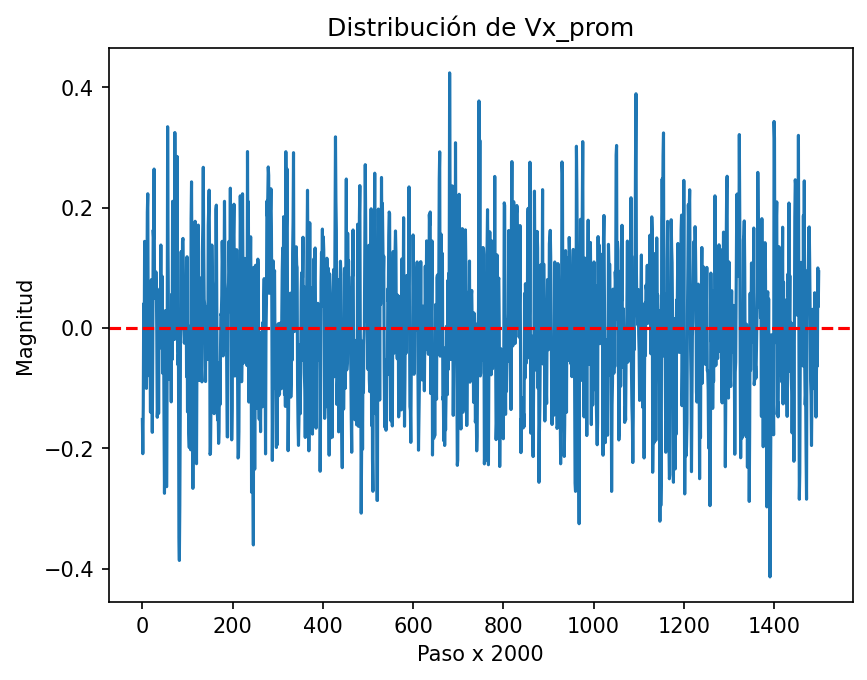

Vy_Mean_vec:  [-0.08737301583656445, -0.11117904222440458, 0.055106067163652794, -0.01501977686061498, 0.04999645317292857, -0.03998709341591283, 0.1884557281195027, 7.539649459137321e-05, -0.13535554744805317, -0.13409130049651918, -0.25051783653685, -0.13950193808720046, -0.09062190270378216, -0.0636218319129566, 0.16400745675055237, -0.013024482832921389, -0.1851454811193649, -0.054521423839884633, 0.04765326309112511, -0.05662818335772395, -0.03502291646562462, 0.07017447863259081, 0.23179257942003617, -0.027358391677513152, -0.06608708752857723, -0.03617381458899344, -0.011874597969133621, -0.04785605115161355, -0.10007687815749408, 0.23047331322495485, 0.13069450655188697, 0.13144286639510178, 0.1649130047751204, 0.17947907389796436, 0.019492293287855622, 0.05712809406340231, 0.18957492055819303, 0.06006610960158178, 0.03080205385182929, 0.17055168923221514, 0.14522718605318552, 0.06441978554076111, 0.12865887276202154, -0.14074538442206952, -0.18735358708392041, 0.05067603658505

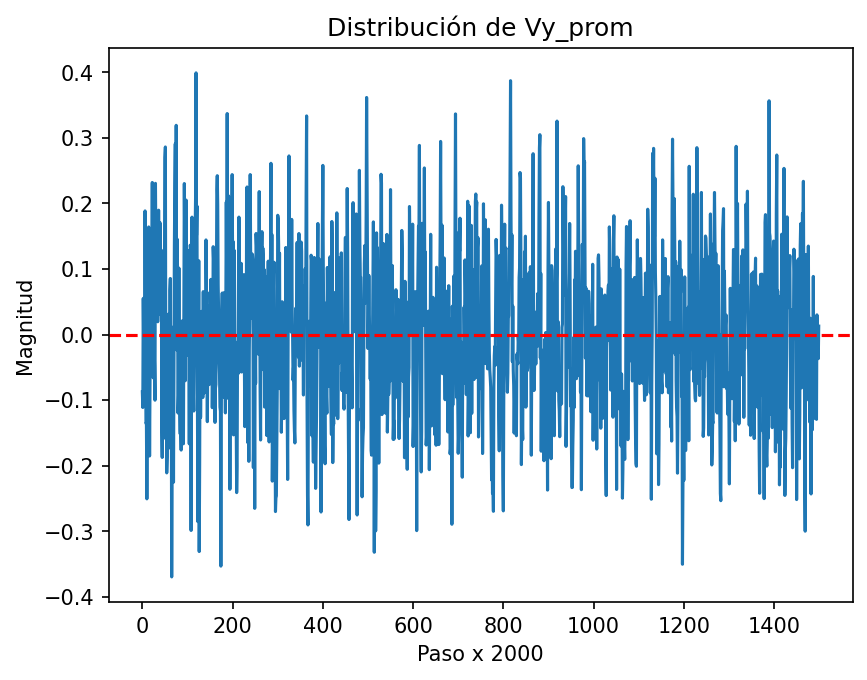

Temperature_Vec:  [0.17065822729085534, 0.18499354619465583, 0.19680288797554274, 0.17452068250648106, 0.23377732740159213, 0.2424165885690218, 0.2456523393566343, 0.1962466030312237, 0.20745738355447185, 0.2480472161945021, 0.247137975845722, 0.20472631506002753, 0.18887242816125033, 0.24661848470202355, 0.16427325369567508, 0.27751671641067227, 0.2996951206816856, 0.2433033852381014, 0.24911567866176282, 0.14599741910415145, 0.14186584621493775, 0.2468206651863504, 0.25547818842575365, 0.2084251182058871, 0.204176200018431, 0.1530165457117697, 0.19841014988113181, 0.2683624567674266, 0.27943408266524694, 0.1822792563420302, 0.18340644652418936, 0.1778866148348724, 0.21075390645118774, 0.22381969866354892, 0.2754234688007503, 0.2540526702349475, 0.2590838633442875, 0.24371565862150177, 0.2121684623903597, 0.1665517580002866, 0.20959876349868783, 0.25820557459371357, 0.2188509033138657, 0.2620335423263665, 0.21291557826588378, 0.1756338204491961, 0.18026694558691642, 0.2607641831071494

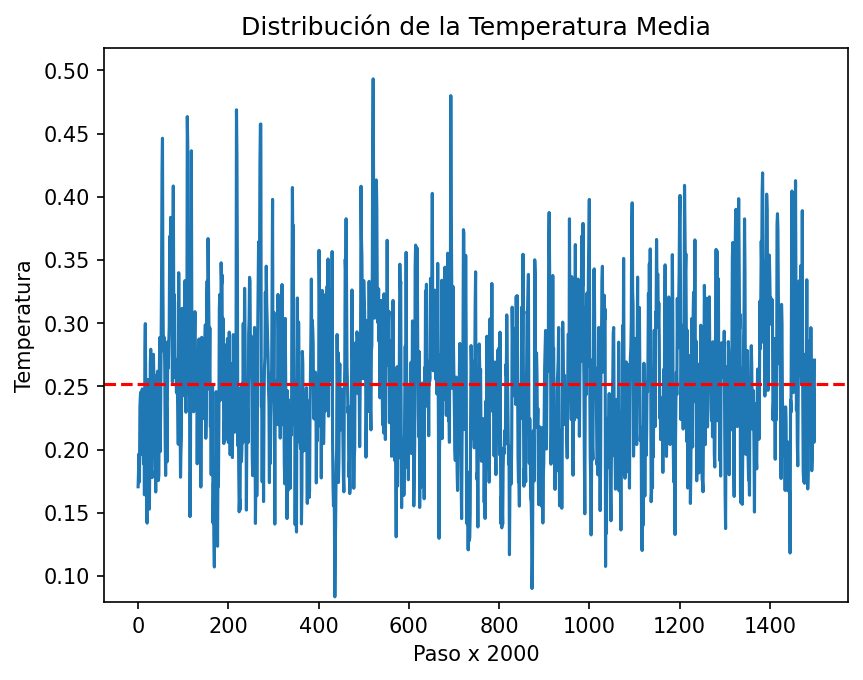

In [10]:

def Ke_Distribution ():
  global Ke_Mean_List

  plt.close("all") #this is the line to be added
  num_steps = len(Ke_Mean_List)
  plt.plot(range(num_steps), Ke_Mean_List)
  plt.xlabel(f'''Paso x {Saving_Steps_Str}''')
  plt.ylabel('Energía cinética')
  plt.title('Distribución de la energía cinética Media')
  Limits = (min(Ke_Mean_List)*0.95,max(Ke_Mean_List)*1.05)
  plt.ylim(Limits)
  if  IDEAL != True:
    plt.axhline(y=np.mean(Ke_Mean_List), color='red', linestyle='--')
  plt.savefig(os.path.join(output_dir, "Ke_Distribution.png"))
  plt.show()

def Vx_Mean_Distribution ():
  global Vx_Mean_vec

  plt.close("all") #this is the line to be added
  num_steps = len(Vx_Mean_vec)
  plt.plot(range(num_steps), Vx_Mean_vec)
  plt.xlabel(f'''Paso x {Saving_Steps_Str}''')
  plt.ylabel('Magnitud')
  plt.title('Distribución de Vx_prom')
  plt.axhline(y=np.mean(Vx_Mean_vec), color='red', linestyle='--')
  plt.savefig(os.path.join(output_dir, "Vx_Mean_Distribution.png"))
  plt.show()

def Vy_Mean_Distribution ():
  global Vy_Mean_vec

  plt.close("all") #this is the line to be added
  num_steps = len(Vy_Mean_vec)
  plt.plot(range(num_steps), Vy_Mean_vec)
  plt.xlabel(f'''Paso x {Saving_Steps_Str}''')
  plt.ylabel('Magnitud')
  plt.title('Distribución de Vy_prom')
  plt.axhline(y=np.mean(Vy_Mean_vec), color='red', linestyle='--')
  plt.savefig(os.path.join(output_dir, "Vy_Mean_Distribution.png"))
  plt.show()

def Temperature_Distribution ():
  global Temperature_Vec

  plt.close("all") #this is the line to be added
  num_steps = len(Temperature_Vec)
  plt.plot(range(num_steps), Temperature_Vec)
  plt.xlabel(f'''Paso x {Saving_Steps_Str}''')
  plt.ylabel('Temperatura')
  plt.title('Distribución de la Temperatura Media')
  Limits = (min(Temperature_Vec)*0.95,max(Temperature_Vec)*1.05)
  plt.ylim(Limits)
  if  IDEAL != True:
    plt.axhline(y=np.mean(Temperature_Vec), color='red', linestyle='--')
  plt.savefig(os.path.join(output_dir, "Temperature_Distribution.png"))
  plt.show()

print("Ke: ",Ke_Mean_List)
print("Ke_Mean: ",np.mean(Ke_Mean_List))
Ke_Distribution()
print("Vx_Mean_vec: ",Vx_Mean_vec)
print("Vx_Mean_vec_Mean: ",np.mean(Vx_Mean_vec))
Vx_Mean_Distribution ()
print("Vy_Mean_vec: ",Vy_Mean_vec)
print("Vy_Mean_vec_Mean: ",np.mean(Vy_Mean_vec))
Vy_Mean_Distribution ()
print("Temperature_Vec: ",Temperature_Vec)
print("Temperature_Vec_Mean: ",np.mean(Temperature_Vec))
Temperature_Distribution()


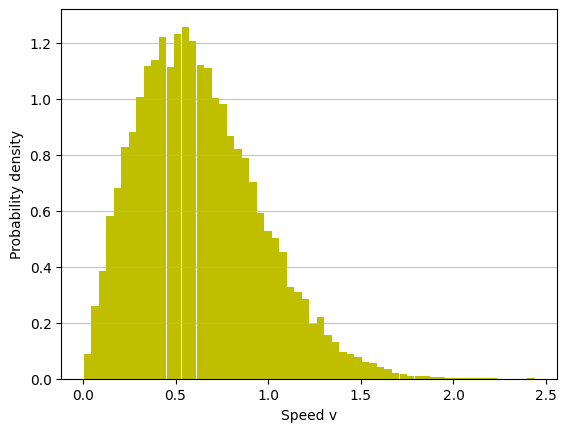

In [11]:
import matplotlib.pyplot as pltHisto

figHisto, axHisto = pltHisto.subplots(dpi=100)  
 

pltHisto.xlabel('Speed v')
pltHisto.ylabel('Probability density')
pltHisto.hist(VmComulate, bins=60, color='y', alpha=1.0, rwidth=0.99, density=True)
pltHisto.grid(axis='y', alpha=0.75)
figHisto.savefig(os.path.join(output_dir, "Distribution_Vel_Histo1.png"))
pltHisto.show()


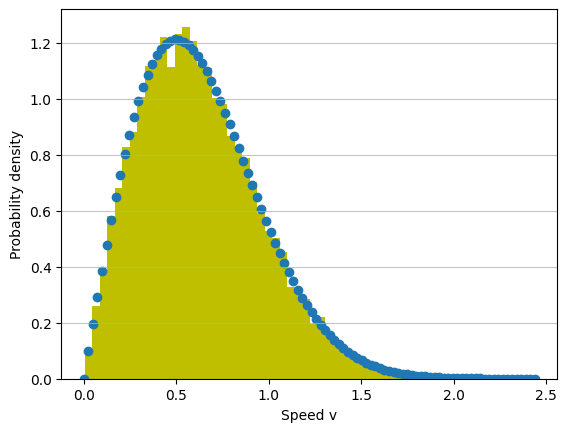

In [12]:
import matplotlib.pyplot as pltHisto2

figHisto2, axHisto2 = pltHisto2.subplots(dpi=100)  

def maxwell_f( v, Temp ) : 
  return (m*v/(kB*Temp))*np.exp(-m*(v**2)/(2*kB*Temp)) 

def maxwell_fPlot( nSteps, vf, Temp ) :
  vList = np.linspace(0, vf, nSteps)
  pltHisto2.scatter(vList, maxwell_f(vList, Temp) )
  pltHisto2.show()
 

pltHisto2.xlabel('Speed v')
pltHisto2.ylabel('Probability density')
pltHisto2.hist(VmComulate, bins=60, color='y', alpha=1.0, rwidth=0.99, density=True)
pltHisto2.grid(axis='y', alpha=0.75)
if IDEAL == True and THERMOSTAT == 'None':
  maxwell_fPlot(100, max(VmComulate), np.mean(Temperature_Vec))
else:
  maxwell_fPlot(100, max(VmComulate), Temp_Target)
figHisto2.savefig(os.path.join(output_dir, "Distribution_Vel_Histo2.png"))
pltHisto2.show()

In [13]:
filename = "animacion2.gif"
output_path = os.path.join(output_dir, filename)

#----------------------------- Animate Graph config ----------------------------

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig2, ax = plt.subplots(2,figsize=(4, 6),gridspec_kw={'height_ratios': [0.8, 0.2]})
frameSteps = 100

#------------ Exec movement with Animate funtion (stack movements) -------------

if ANIMATE2 == True:
    ani2 = matplotlib.animation.FuncAnimation(fig2, animate, frames=frameSteps)
    ani2.save(output_path, writer="Pillow")
    
# matplotlib.animation.FuncAnimation(fig2, animate, frames=frameSteps)


MovieWriter Pillow unavailable; using Pillow instead.


n1 = 1  of  100
n1 = 1  of  100
n1 = 2  of  100
n1 = 3  of  100
n1 = 4  of  100
n1 = 5  of  100
n1 = 6  of  100
n1 = 7  of  100
n1 = 8  of  100
n1 = 9  of  100
n1 = 10  of  100
n1 = 11  of  100
n1 = 12  of  100
n1 = 13  of  100
n1 = 14  of  100
n1 = 15  of  100
n1 = 16  of  100
n1 = 17  of  100
n1 = 18  of  100
n1 = 19  of  100
n1 = 20  of  100
n1 = 21  of  100
n1 = 22  of  100
n1 = 23  of  100
n1 = 24  of  100
n1 = 25  of  100
n1 = 26  of  100
n1 = 27  of  100
n1 = 28  of  100
n1 = 29  of  100
n1 = 30  of  100
n1 = 31  of  100
n1 = 32  of  100
n1 = 33  of  100
n1 = 34  of  100
n1 = 35  of  100
n1 = 36  of  100
n1 = 37  of  100
n1 = 38  of  100
n1 = 39  of  100
n1 = 40  of  100
n1 = 41  of  100
n1 = 42  of  100
n1 = 43  of  100
n1 = 44  of  100
n1 = 45  of  100
n1 = 46  of  100
n1 = 47  of  100
n1 = 48  of  100
n1 = 49  of  100
n1 = 50  of  100
n1 = 51  of  100
n1 = 52  of  100
n1 = 53  of  100
n1 = 54  of  100
n1 = 55  of  100
n1 = 56  of  100
n1 = 57  of  100
n1 = 58  of  100
n1 = 59

In [14]:
def guardar_csv(arr, variable_name, output_dir):
    file_name = f"{variable_name}.csv"
    file_path = os.path.join(output_dir, file_name)
    
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='|', quoting=csv.QUOTE_MINIMAL)
        
        for item in arr:
            if isinstance(item, float):
                formatted_item = "{:.9}".format(item).replace('.', ',')
                writer.writerow([formatted_item])
            else:
                writer.writerow([item])
    
guardar_csv(Ke_Mean_List, "Ke_Mean_List",output_dir)
print("Ke_Mean: ",np.mean(Ke_Mean_List))

guardar_csv(Vx_Mean_vec, "Vx_Mean_vec",output_dir)
print("Vx_Mean_vec_Mean: ",np.mean(Vx_Mean_vec))

guardar_csv(Vy_Mean_vec, "Vy_Mean_vec",output_dir)
print("Vy_Mean_vec_Mean: ",np.mean(Vy_Mean_vec))

guardar_csv(Temperature_Vec, "Temperature_Vec",output_dir)
print("Temperature_Vec_Mean: ",np.mean(Temperature_Vec))

Ke_Mean:  0.2518021417893777
Vx_Mean_vec_Mean:  -0.0006335413132054562
Vy_Mean_vec_Mean:  -0.001160049785819071
Temperature_Vec_Mean:  0.2518021417893777


In [15]:
import datetime
import os
import asyncio
from telegram import Bot

async def enviar_mensaje_telegram(token, chat_id, output_dir):
    hora_finalizacion = datetime.datetime.now().strftime('%H:%M:%S')
    fecha_finalizacion = datetime.datetime.now().strftime('%Y-%m-%d')

    mensaje_completo = f'''
    {PC_ID}: La simulación ha finalizado correctamente.

    Hora de finalización: {hora_finalizacion}
    Fecha de finalización: {fecha_finalizacion}
    Directorio de resultados: {output_dir}
    '''

    bot = Bot(token=token)
    await bot.send_message(chat_id=chat_id, text=mensaje_completo)

    # Obtener la lista de archivos en el directorio
    archivos = os.listdir(output_dir)

    # Enviar cada archivo que no sea .csv por Telegram
    for archivo in archivos:
        ruta_archivo = os.path.join(output_dir, archivo)
        if not archivo.endswith('.csv'):
            await bot.send_document(chat_id=chat_id, document=open(ruta_archivo, 'rb'))

async def main():
    global output_dir
    token = "6105465299:AAG-yMSYxqHqFpoomJt1J2BNjazHukQ2cZo"
    chat_id = "5205937784"

    await enviar_mensaje_telegram(token, chat_id, output_dir)

loop = asyncio.get_event_loop()
asyncio.create_task(main())


<Task pending name='Task-5' coro=<main() running at C:\Users\crist\AppData\Local\Temp\ipykernel_16512\582908798.py:30>>

In [16]:
# Obtén todas las variables locales como un diccionario
variables = dict(locals())

# Nombre personalizado para el archivo CSV
nombre_archivo_csv = 'Simulation_Values.csv'

# Ruta completa del archivo CSV con el directorio y nombre personalizado
ruta_archivo_csv = f"{output_dir}/{nombre_archivo_csv}"

# Crear un DataFrame de Pandas con las variables y sus valores
df = pd.DataFrame(list(variables.items()), columns=['Variable', 'Valor'])

# Guardar el DataFrame en un archivo CSV con delimitador de coma
df.to_csv(ruta_archivo_csv, index=False)